## 1.1 ASHARE-Start here: A gentle introduction

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2022.06.03 </div> 
<div style="text-align: right"> Last update: 2022.06.03</div> 

- https://www.kaggle.com/code/caesarlupum/ashrae-start-here-a-gentle-introduction

데이터 소개

> #### train.csv
- building_id - Foreign key for the building metadata.
- meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
- timestamp - When the measurement was taken
- meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.
> #### building_meta.csv
- site_id - Foreign key for the weather files.
- building_id - Foreign key for training.csv
- primary_use - Indicator of the primary category of activities for the building based on [EnergyStar](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type) property type definitions
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building
> #### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- site_id
- air_temperature - Degrees Celsius
- cloud_coverage - Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta)
- dew_temperature - Degrees Celsius
- precip_depth_1_hr - Millimeters
- sea_level_pressure - Millibar/hectopascals
- wind_direction - Compass direction (0-360)
- wind_speed - Meters per second
> #### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

row_id - Row id for your submission file
- building_id - Building id code
- meter - The meter id code
- timestamp - Timestamps for the test data period
> ####  sample_submission.csv
A valid sample submission.

metric

We will be evaluated by the metirc `Root Mean Squared Logarithmic Error`.

The RMSLE is calculated as:
The RMSLE is calculated as

$ ϵ=1n∑i= \sqrt{ 1/n (log(pi+1)−log(ai+1))^2 } $
Where:

- ϵ is the RMSLE value (score)
- n is the total number of observations in the (public/private) data set,
- pi is your prediction of target, and
- ai is the actual target for i.
- log(x) is the natural logarithm of x

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

### 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

In [2]:
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle  

### 데이터 읽기

In [3]:
print(os.listdir('data/ashrae-energy-prediction/'))

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'train.csv', 'weather_test.csv', 'weather_train.csv']


In [4]:
%%time
root = 'data/ashrae-energy-prediction/'

train_df = pd.read_csv(root +'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: total: 15 s
Wall time: 16.8 s


### 데이터 사이즈

In [5]:
train_df.shape

(20216100, 4)

In [6]:
weather_train_df.shape

(139773, 9)

In [7]:
weather_test_df.shape

(277243, 9)

In [8]:
building_meta_df.shape

(1449, 6)

### 메모리 사이즈 줄이기

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


### 데이터 살펴보기

In [11]:
display(train_df)
display(train_df.columns.values)

display(weather_train_df.head())
display(weather_train_df.columns.values)

display(building_meta_df.head())
display(building_meta_df.columns.values)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

### EDA

#### 타겟 분포

<AxesSubplot:>

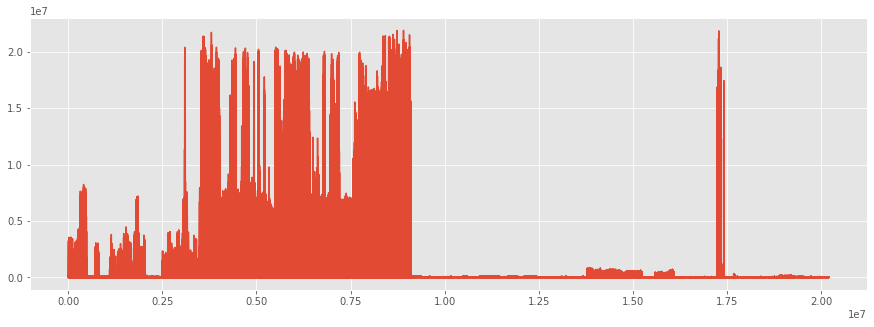

In [12]:
plt.figure(figsize=(15, 5))
train_df['meter_reading'].plot()

<AxesSubplot:title={'center':'Distributin of target'}, ylabel='Frequency'>

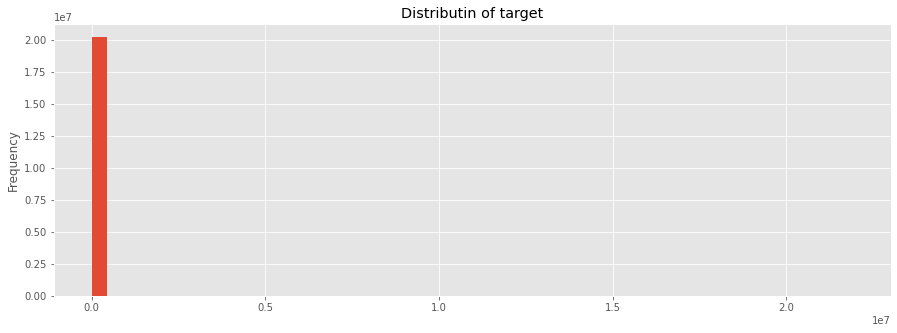

In [13]:
train_df['meter_reading'].plot(kind = 'hist', bins=50, figsize=(15, 5), title = 'Distributin of target')

#### 결측치와 0 계측 값 시각화

각 건물 및 계량기에 대해 결측치와 0 계측이 발생한 시간대를 시각화

In [14]:
train = train_df.set_index('timestamp')

In [15]:
train.head()

,building_id,meter,meter_reading
timestamp,,,
2016-01-01,0,0,0.0
2016-01-01,1,0,0.0
2016-01-01,2,0,0.0
2016-01-01,3,0,0.0
2016-01-01,4,0,0.0


TypeError: dtype datetime64[ns] cannot be converted to timedelta64[ns]

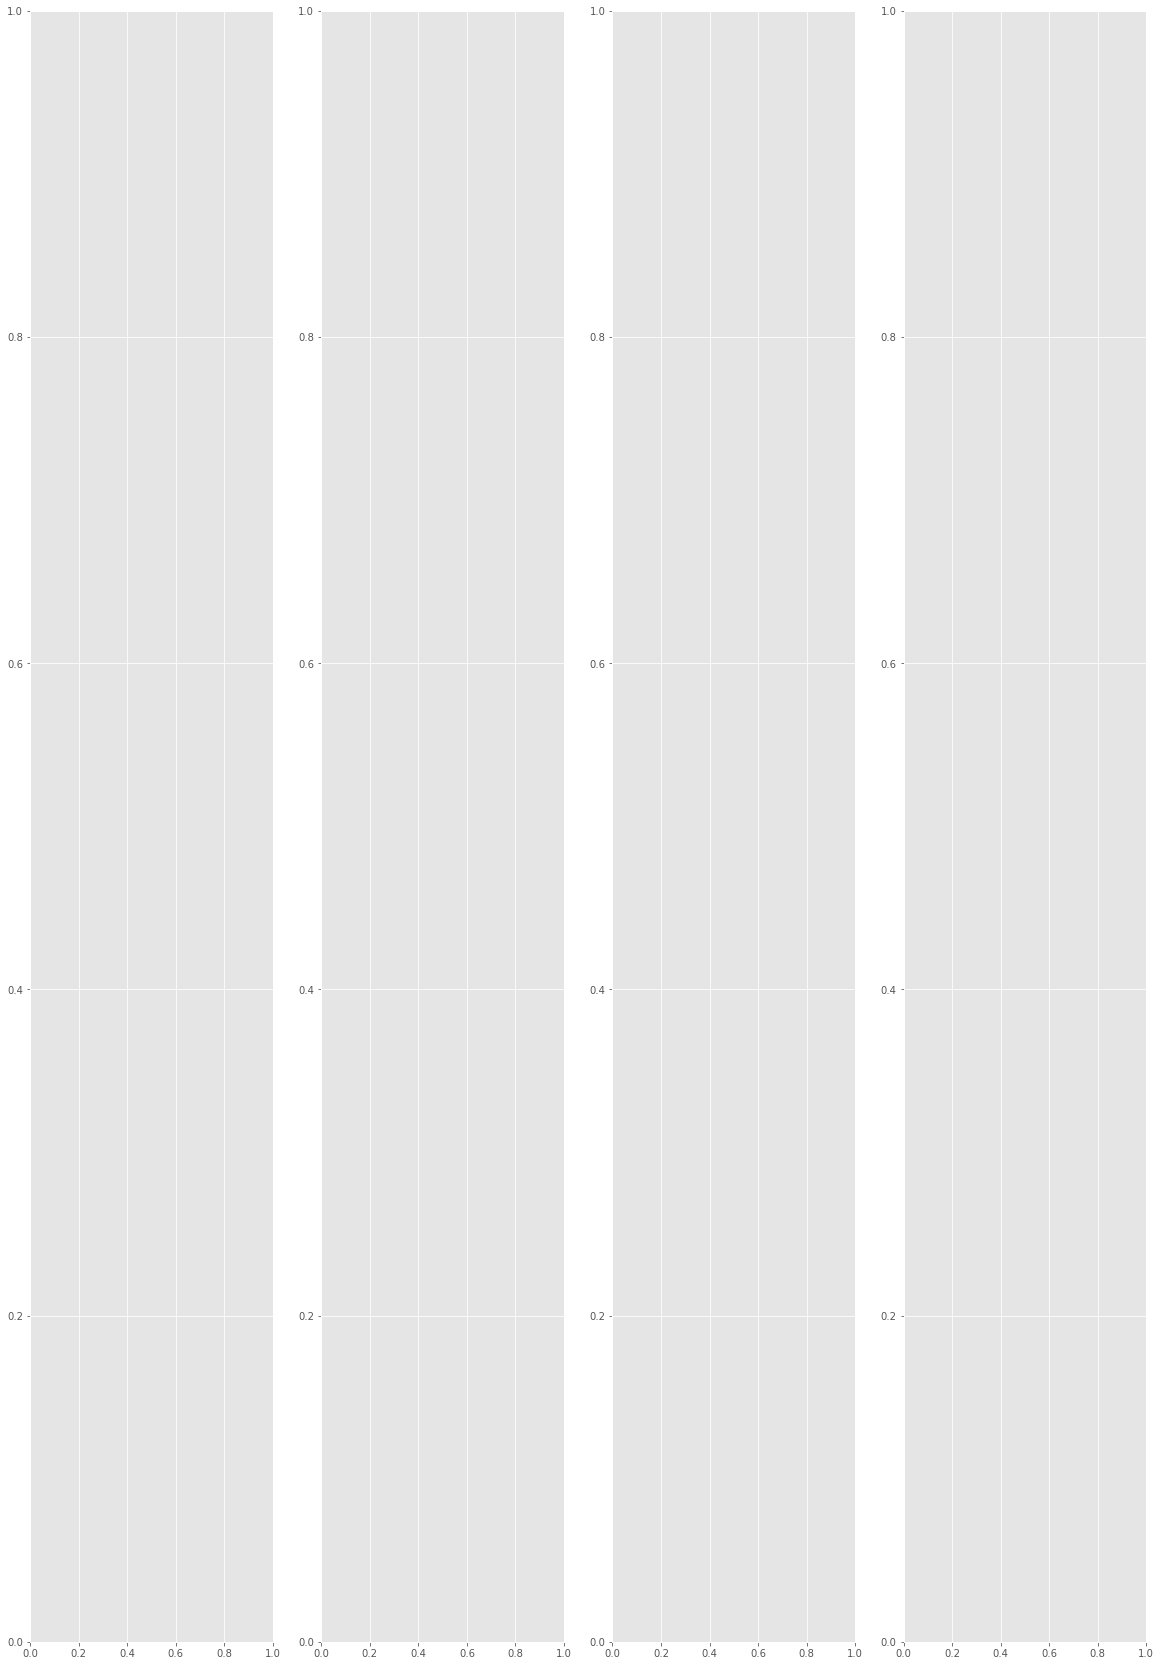

In [39]:
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

- Vertical blue lines may be suspicious

Legend:
* X axis: hours elapsed since Jan 1st 2016, for each of the 4 meter types
* Y axis: building_id
* Brown: meter reading available with non-zero value
* Light blue: meter reading available with zero value
* White: missing meter reading
    
-- 다시 해볼 것

#### 결측치 확인

train_df

In [16]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)

In [17]:
total

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [18]:
percent

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [19]:
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(4)

,Total,Percent
building_id,0,0.0
meter,0,0.0
timestamp,0,0.0
meter_reading,0,0.0


weather_train_df

In [20]:
total = weather_train_df.isnull().sum().sort_values(ascending=False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data.head(9)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


In [22]:
weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [23]:
weather_train_df.isnull().count()

site_id               139773
timestamp             139773
air_temperature       139773
cloud_coverage        139773
dew_temperature       139773
precip_depth_1_hr     139773
sea_level_pressure    139773
wind_direction        139773
wind_speed            139773
dtype: int64

weather_test_df

In [24]:
total = weather_test_df.isnull().sum().sort_values(ascending = False)
percent = (weather_test_df.isnull().sum()/weather_test_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_test_data.head(9)

,Total,Percent
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
site_id,0,0.000000
timestamp,0,0.000000


building_meta_df

In [25]:
total = building_meta_df.isnull().sum().sort_values(ascending = False)
percent = (building_meta_df.isnull().sum()/building_meta_df.isnull().count()*100).sort_values(ascending = False)
missing_building_meta_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


#### 6.4 Column types

In [26]:
train_df.dtypes.value_counts()

int16             1
int8              1
datetime64[ns]    1
float32           1
dtype: int64

In [27]:
# Number of unique classes in each object column
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

#### 상관도 분석

카테고리 변수와 이상치를 체크해보자.  

피어슨 상관도도....
- http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf

피어슨 상관도.

* .00-.19 “**very weak**”
*  .20-.39 “**weak**”
*  .40-.59 “**moderate**”
*  .60-.79 “**strong**”
* .80-1.0 “**very strong**”

In [28]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [29]:
train_df.corr()

,building_id,meter,meter_reading
building_id,1.000000,0.222268,0.008761
meter,0.222268,1.000000,0.017672
meter_reading,0.008761,0.017672,1.000000


In [30]:
# 미터 리딩과 다른 변수간 상관도  

correlations = train_df.corr()['meter_reading'].sort_values()

In [35]:
correlations

building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64

In [36]:
corr = train_df.corr()

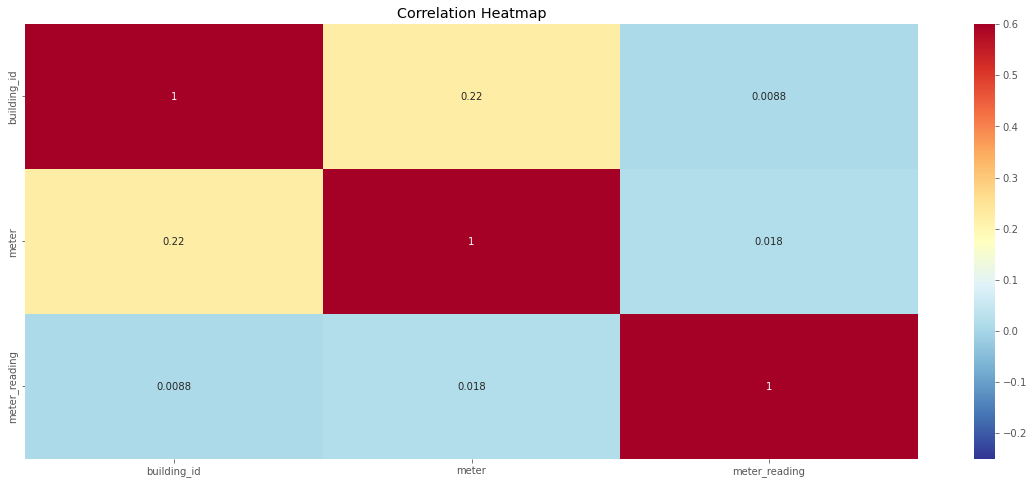

In [38]:
# 히트맵 그리기  

plt.figure(figsize = (20, 8))

# Heatmap of correlations
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

### plotting

In [39]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [40]:
train_df['building_id'].nunique()

1449

측정값 분포

<AxesSubplot:>

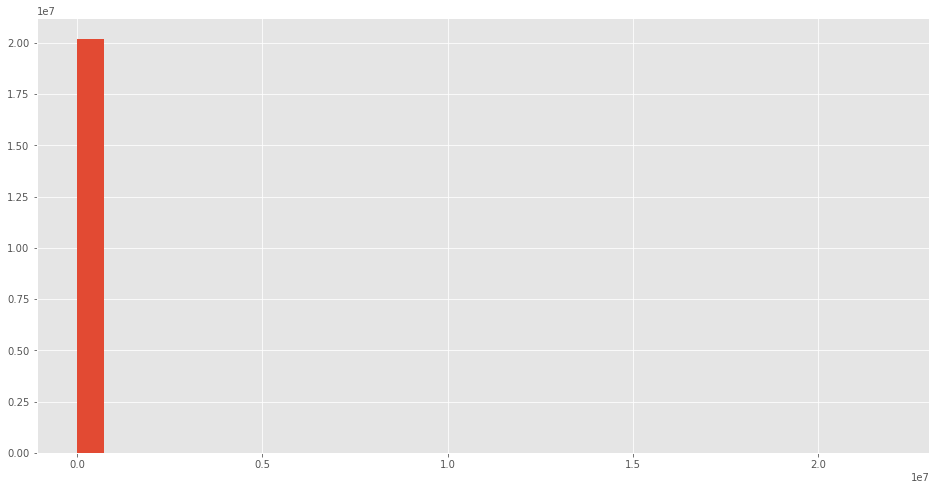

In [41]:
train_df['meter_reading'].hist(bins = 30, figsize = (16, 8))

In [44]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [42]:
def plot_dist_col(column):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.distplot(weather_train_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test_df[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

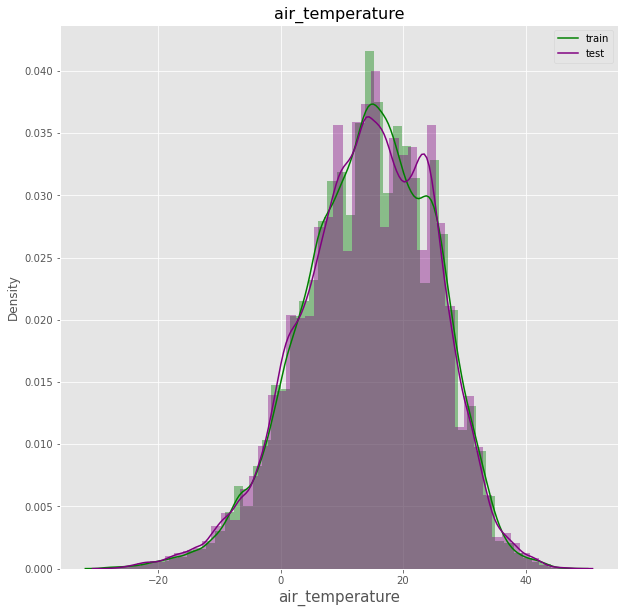

In [43]:
plot_dist_col('air_temperature')

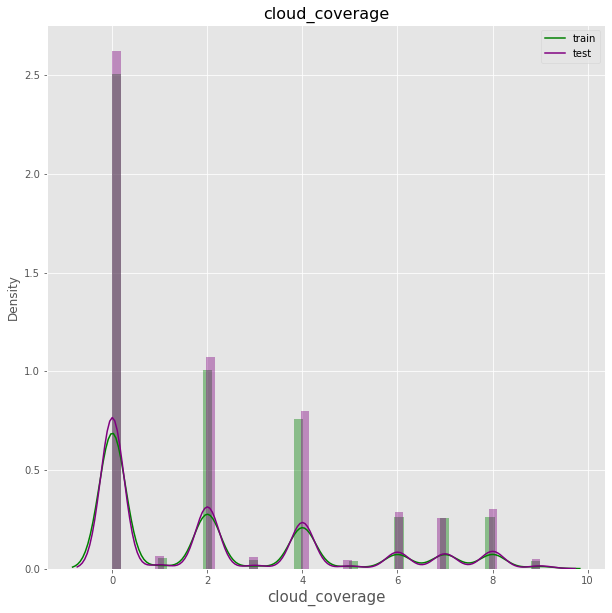

In [45]:
plot_dist_col('cloud_coverage')

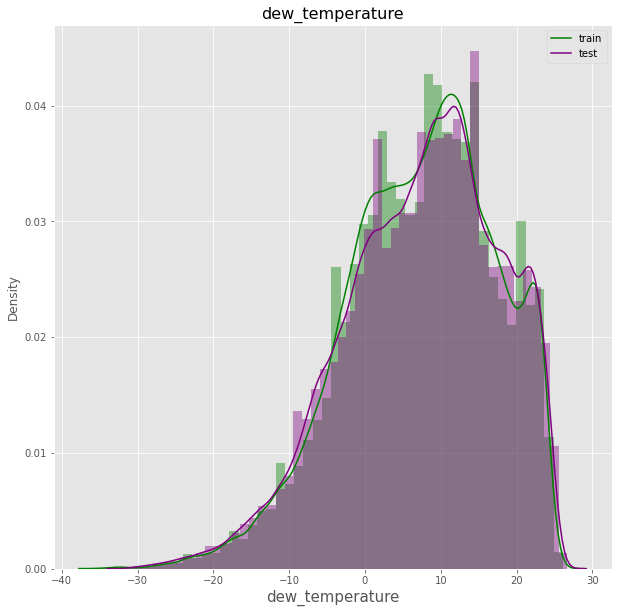

In [46]:
plot_dist_col('dew_temperature')

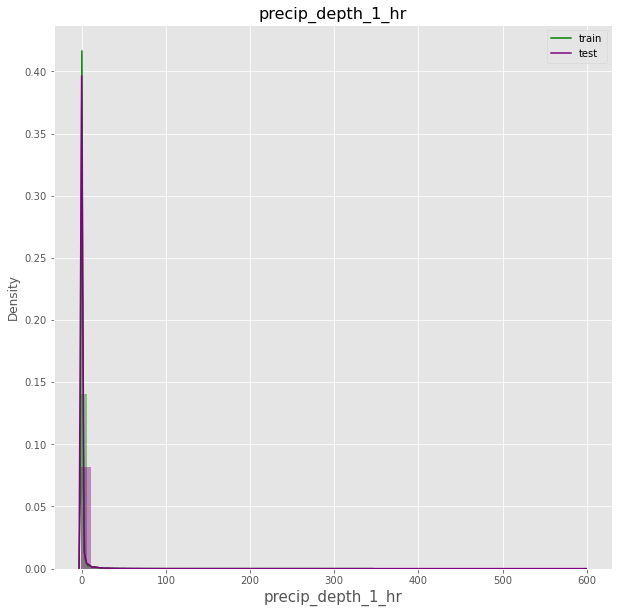

In [47]:
plot_dist_col('precip_depth_1_hr')

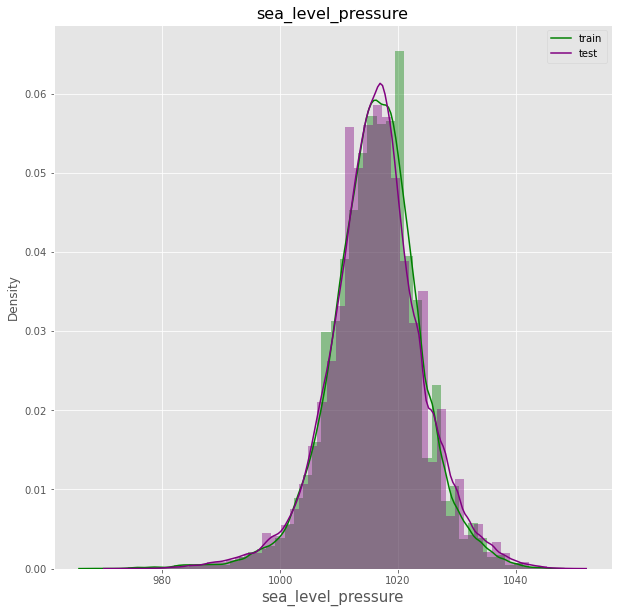

In [48]:
plot_dist_col('sea_level_pressure')

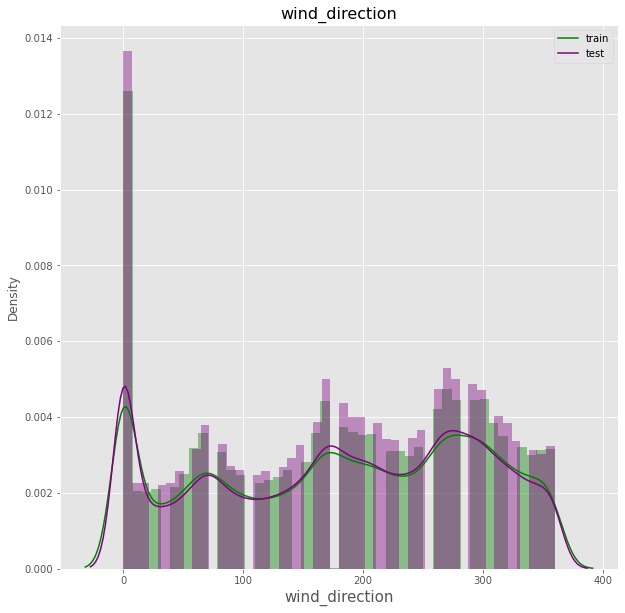

In [49]:
plot_dist_col('wind_direction')

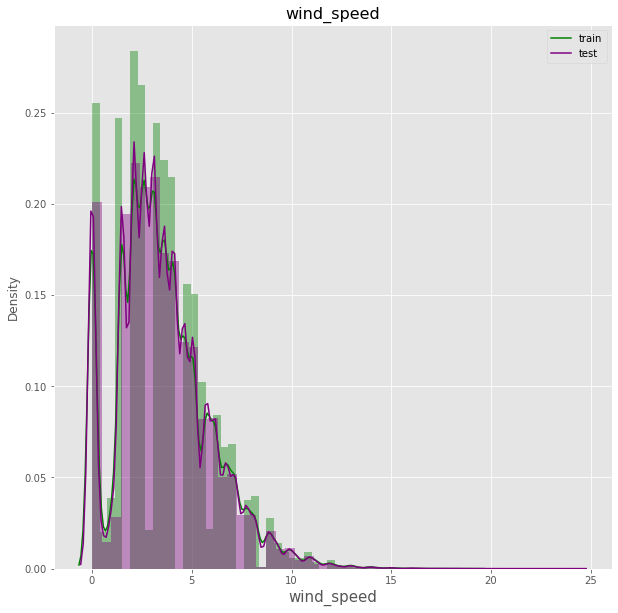

In [50]:
plot_dist_col('wind_speed')

### Simple Single Series Analysis

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [52]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [54]:
# 시간대별 전체 미터리딩 합

ts = train_df.groupby(['timestamp'])['meter_reading'].sum()

In [55]:
ts.head()

timestamp
2016-01-01 00:00:00    4211283.500
2016-01-01 01:00:00    4251482.000
2016-01-01 02:00:00    1259595.375
2016-01-01 03:00:00    1009027.125
2016-01-01 04:00:00    1170655.500
Name: meter_reading, dtype: float32

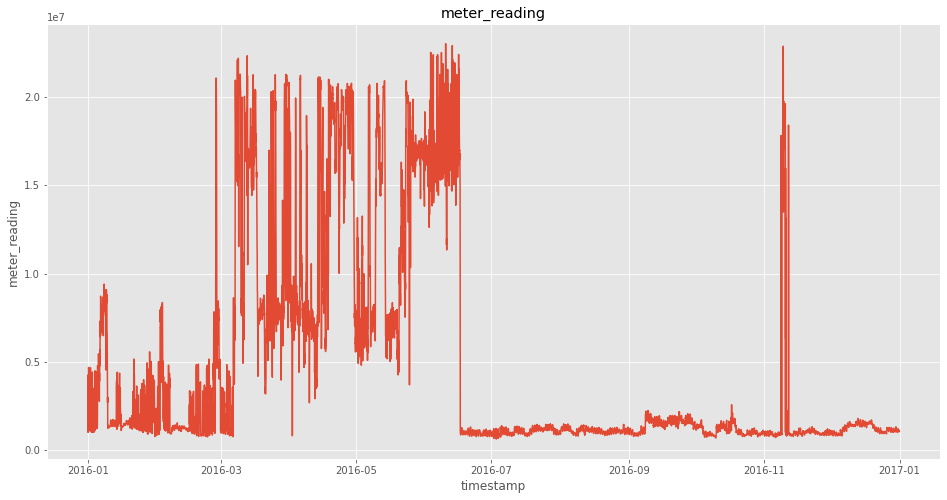

In [56]:
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

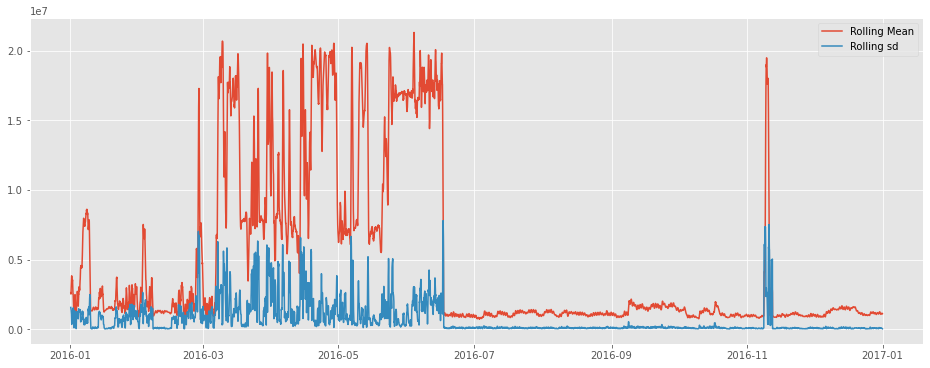

In [57]:
plt.figure(figsize = (16, 6))
plt.plot(ts.rolling(window = 12, center=False).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window = 12, center=False).std(), label='Rolling sd')
plt.legend()

In [58]:
import statsmodels.api as sm

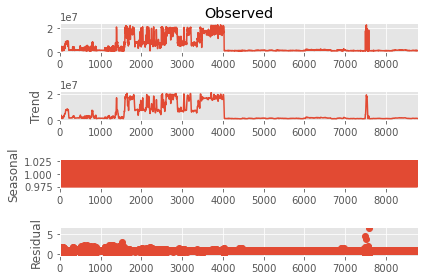

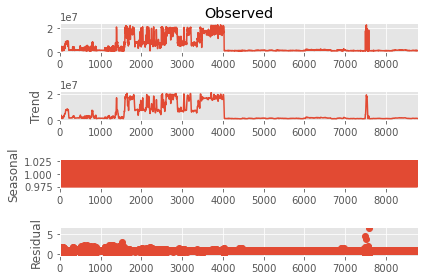

In [65]:
res = sm.tsa.seasonal_decompose(ts.values, period=12, model = 'multiplicative')
res.plot()

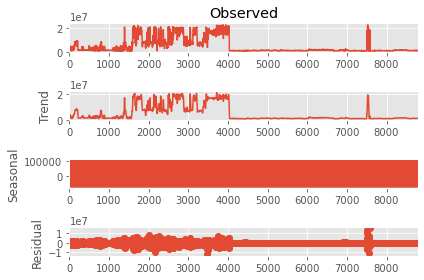

In [66]:
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
fig = res.plot()

### Outlier detection

<AxesSubplot:xlabel='timestamp'>

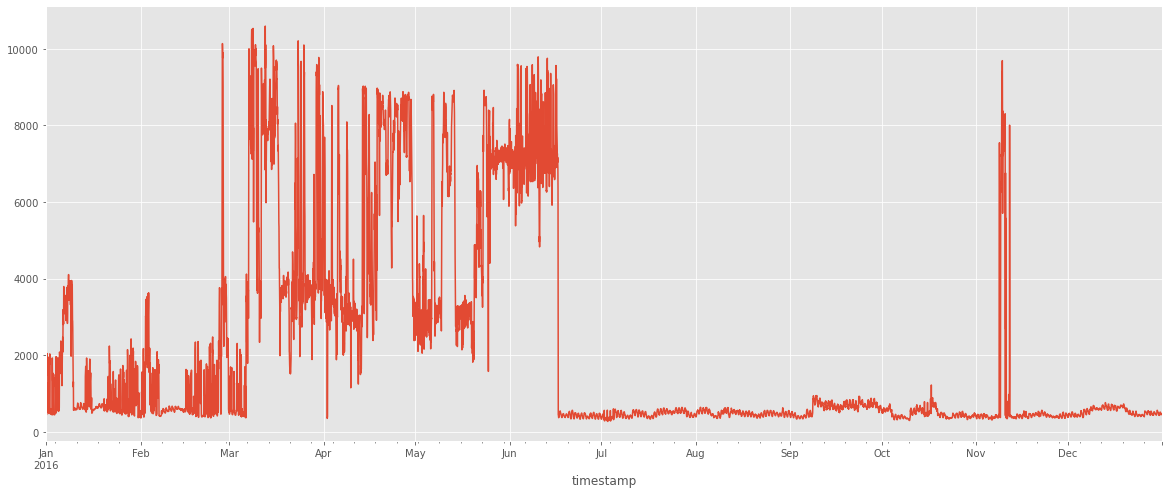

In [69]:
y_mean_time = train_df.groupby('timestamp')['meter_reading'].mean()
y_mean_time.plot(figsize = (20, 8))

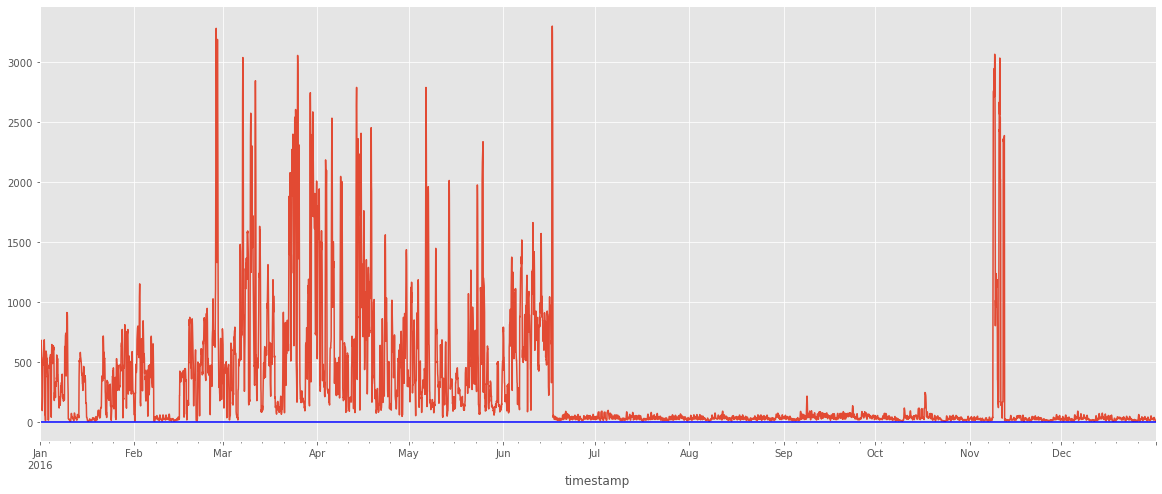

In [71]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
ax = plt.axhline(y=0.009, color='b')

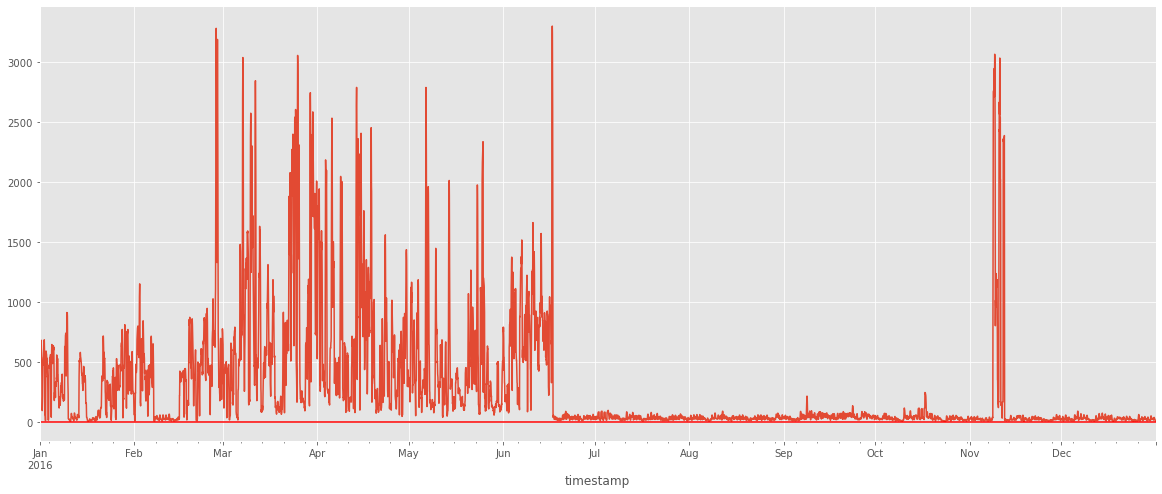

In [72]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green', alpha=0.1)
plt.axvspan(906, 1505, color='red', alpha=0.1)

### Group data in daily basis

- https://www.kaggle.com/code/juanmah/ashrae-outliers/notebook 

In [73]:
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})

In [74]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,electricity,2016-01-01,0.0
1,1,electricity,2016-01-01,0.0
2,2,electricity,2016-01-01,0.0
3,3,electricity,2016-01-01,0.0
4,4,electricity,2016-01-01,0.0


In [75]:
daily_train = train_df.copy()
daily_train['date'] = daily_train['timestamp'].dt.date

In [76]:
daily_train.head()

,building_id,meter,timestamp,meter_reading,date
0,0,electricity,2016-01-01,0.0,2016-01-01
1,1,electricity,2016-01-01,0.0,2016-01-01
2,2,electricity,2016-01-01,0.0,2016-01-01
3,3,electricity,2016-01-01,0.0,2016-01-01
4,4,electricity,2016-01-01,0.0,2016-01-01


In [77]:
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

meter_reading
date       building_id meter                      
2016-01-01 0           electricity        0.000000
                       chilledwater       0.000000
                       steam              0.000000
                       hotwater           0.000000
           1           electricity        0.000000
...                                            ...
2016-12-31 1447        hotwater           0.000000
           1448        electricity       79.974998
                       chilledwater       0.000000
                       steam              0.000000
                       hotwater           0.000000

[2121336 rows x 1 columns]

### Aggregate the data for buildings

In [79]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])

In [80]:
daily_train_agg.head()

meter_reading                \
                                  sum          mean   
date       meter                                      
2016-01-01 electricity   4.219648e+06   2912.109863   
           chilledwater  1.412169e+06    974.581665   
           steam         6.873201e+07  47434.097656   
           hotwater      1.609989e+06   1111.103760   
2016-01-02 electricity   4.288951e+06   2959.938721   

                                                                         
                                                   idxmax           max  
date       meter                                                         
2016-01-01 electricity     (2016-01-01, 803, electricity)  1.160372e+05  
           chilledwater  (2016-01-01, 1289, chilledwater)  1.042116e+05  
           steam                (2016-01-01, 1099, steam)  5.095080e+07  
           hotwater          (2016-01-01, 1331, hotwater)  2.198245e+05  
2016-01-02 electricity     (2016-01-02, 803, electricity)  1.157768e+05

In [81]:
daily_train_agg = daily_train_agg.reset_index()

In [82]:
daily_train_agg.head()

date         meter meter_reading                \
                                      sum          mean   
0  2016-01-01   electricity  4.219648e+06   2912.109863   
1  2016-01-01  chilledwater  1.412169e+06    974.581665   
2  2016-01-01         steam  6.873201e+07  47434.097656   
3  2016-01-01      hotwater  1.609989e+06   1111.103760   
4  2016-01-02   electricity  4.288951e+06   2959.938721   

                                                   
                             idxmax           max  
0    (2016-01-01, 803, electricity)  1.160372e+05  
1  (2016-01-01, 1289, chilledwater)  1.042116e+05  
2         (2016-01-01, 1099, steam)  5.095080e+07  
3      (2016-01-01, 1331, hotwater)  2.198245e+05  
4    (2016-01-02, 803, electricity)  1.157768e+05

In [83]:
level_0 = daily_train_agg.columns.droplevel(0)

In [84]:
level_0

Index(['', '', 'sum', 'mean', 'idxmax', 'max'], dtype='object')

In [85]:
level_1 = daily_train_agg.columns.droplevel(1)

In [86]:
level_1

Index(['date', 'meter', 'meter_reading', 'meter_reading', 'meter_reading',
       'meter_reading'],
      dtype='object')

In [87]:
level_0 = ['' if x == '' else '-' + x for x in level_0]

In [88]:
level_0

['', '', '-sum', '-mean', '-idxmax', '-max']

In [89]:
daily_train_agg.columns = level_1 + level_0

In [90]:
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,2912.109863,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,974.581665,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,47434.097656,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,1111.103760,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,2959.938721,"(2016-01-02, 803, electricity)",1.157768e+05


In [91]:
daily_train_agg.rename_axis(None, axis=1)

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,2912.109863,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,974.581665,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,47434.097656,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,1111.103760,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,2959.938721,"(2016-01-02, 803, electricity)",1.157768e+05
...,...,...,...,...,...,...
1459,2016-12-30,hotwater,2.077853e+06,1433.990967,"(2016-12-30, 1021, hotwater)",5.124206e+05
1460,2016-12-31,electricity,5.066865e+06,3496.801270,"(2016-12-31, 799, electricity)",1.343883e+05
1461,2016-12-31,chilledwater,2.102037e+06,1450.681274,"(2016-12-31, 50, chilledwater)",8.256347e+04
1462,2016-12-31,steam,1.718295e+07,11858.492188,"(2016-12-31, 1168, steam)",1.324875e+06


In [92]:
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,2912.109863,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,974.581665,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,47434.097656,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,1111.103760,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,2959.938721,"(2016-01-02, 803, electricity)",1.157768e+05


some plots

In [93]:
fig_total = px.line(daily_train_agg, x = 'date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

In [94]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

### Identifying outliers

In [95]:
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,2912.109863,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,974.581665,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,47434.097656,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,1111.103760,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,2959.938721,"(2016-01-02, 803, electricity)",1.157768e+05


In [96]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4.219648e+06,2912.109863,"(2016-01-01, 803, electricity)",1.160372e+05,803
1,2016-01-01,chilledwater,1.412169e+06,974.581665,"(2016-01-01, 1289, chilledwater)",1.042116e+05,1289
2,2016-01-01,steam,6.873201e+07,47434.097656,"(2016-01-01, 1099, steam)",5.095080e+07,1099
3,2016-01-01,hotwater,1.609989e+06,1111.103760,"(2016-01-01, 1331, hotwater)",2.198245e+05,1331
4,2016-01-02,electricity,4.288951e+06,2959.938721,"(2016-01-02, 803, electricity)",1.157768e+05,803


In [97]:
def show_building(building, energy_aspects=None):
    fig = px.line(daily_train.loc[(slice(None), building, slice(None)), :].reset_index(),
                  x='date',
                  y='meter_reading',
                  color='meter',
                  render_mode='svg')
    if energy_aspects:
        if 'electricity' not in energy_aspects:
            fig['data'][0].visible = 'legendonly'
        if 'chilledwater' not in energy_aspects:
            fig['data'][1].visible = 'legendonly'
        if 'steam' not in energy_aspects:
            fig['data'][2].visible = 'legendonly'
        if 'hotwater' not in energy_aspects:
            fig['data'][3].visible = 'legendonly'
    fig.update_layout(title='Building ID: {}'.format(building))        
    fig.show()
    display(building_metadata[building_metadata['building_id']==building])

Electricity

In [98]:
print('Number of days that a building has the maximum electricity consumption of all the buildings:\n')
# 특정 빌딩이 전기 사용량이 최대였던 날 횟수
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())

Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
794       1
993       1
Name: building_id_max, dtype: int64


- 6개 빌딩에 의해서 전력사용량의 최대 값이 발생한다.

In [99]:
daily_train_electricity = daily_train_agg[daily_train_agg['meter']=='electricity'].copy()
daily_train_electricity['building_id_max'] = pd.Categorical(daily_train_electricity['building_id_max'])

In [100]:
daily_train_electricity.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4219647.5,2912.109863,"(2016-01-01, 803, electricity)",116037.179688,803
4,2016-01-02,electricity,4288951.0,2959.938721,"(2016-01-02, 803, electricity)",115776.750000,803
8,2016-01-03,electricity,4247301.0,2931.194824,"(2016-01-03, 803, electricity)",115708.132812,803
12,2016-01-04,electricity,5005502.5,3454.453125,"(2016-01-04, 803, electricity)",124764.109375,803
16,2016-01-05,electricity,5095315.5,3516.435791,"(2016-01-05, 803, electricity)",125209.890625,803


In [101]:
fig_daily_electricity = px.scatter(daily_train_electricity,
                                   x='date',
                                   y='meter_reading-max',
                                   color='building_id_max',
                                   render_mode='svg')
fig_daily_electricity.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_electricity.show()

Chilledwater

In [102]:
print('Number of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())

Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    134
76       92
1258     41
1289     38
778      37
29       10
1088     10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64


In [103]:
daily_train_chilledwater = daily_train_agg[daily_train_agg['meter']=='chilledwater'].copy()
daily_train_chilledwater['building_id_max'] = pd.Categorical(daily_train_chilledwater['building_id_max'])
fig_daily_chilledwater = px.scatter(daily_train_chilledwater,
                                    x='date',
                                    y='meter_reading-max',  
                                    color='building_id_max', 
                                    render_mode='svg')
fig_daily_chilledwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_chilledwater.show()

steam

In [104]:
print('Number of days that a building has the maximum steam consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())

Number of days that a building has the maximum steam consumption of all the buildings:

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64


- The max values of electricity are caused by only 4 buildings.

In [105]:
daily_train_steam = daily_train_agg[daily_train_agg['meter']=='steam'].copy()
daily_train_steam['building_id_max'] = pd.Categorical(daily_train_steam['building_id_max'])
fig_daily_steam = px.scatter(daily_train_steam,
                             x='date',
                             y='meter_reading-max',
                             color='building_id_max',
                             render_mode='svg')
fig_daily_steam.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_steam.show()

hotwater

In [106]:
print('Number of days that a building has the maximum hotwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].value_counts())

Number of days that a building has the maximum hotwater consumption of all the buildings:

1021    229
1331    120
794       7
1317      7
1232      1
1323      1
1252      1
Name: building_id_max, dtype: int64


- The max values of electricity are caused by only 7 buildings. Practically, two of them

In [107]:
daily_train_hotwater = daily_train_agg[daily_train_agg['meter']=='hotwater'].copy()
daily_train_hotwater['building_id_max'] = pd.Categorical(daily_train_hotwater['building_id_max'])
fig_daily_hotwater = px.scatter(daily_train_hotwater,
                                x='date',
                                y='meter_reading-max',
                                color='building_id_max',
                                render_mode='svg')
fig_daily_hotwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_hotwater.show()

### 결측치 검사

Taking only the buildings that consume more than the others, could be seen that there are a lot of measure scale errors.
    The error could be:

    The meter is not configured correctly. E.g., a bad voltage or current primary to secondary ratio.
    The software has not the units configured correctly. E.g., MJ/kg for steam.
    The software has not the decimal digits configured correctly.
    Using a power variable instead of an energy one.
    The measure could be done with an unique meter, or the sum of several of them.

    Some changes over time, values go to zero or the scale is changed, indicates that some buildings have more than one meter. One error in one meter and the overall measure is garbage.

    This notebook has only analised the outliers that influence the maximum consumption in a daily basis. This is only the tip of the iceberg. A sound analysis should be done to detect and correct these outliers.

    A solution to avoid scale errors is to normalize the values from 0 to 1, for each building and for each energy aspect.

### Simple Feature engineering modeling

In [108]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [110]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

#### buiding df merge

In [111]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [112]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [113]:
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [114]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [115]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

In [116]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN
1,1,electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN
2,2,electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN
3,3,electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN
4,4,electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN


In [117]:
temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

In [118]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01,0,Education,7432,2008.0,NaN
1,1,1,0,2017-01-01,0,Education,2720,2004.0,NaN
2,2,2,0,2017-01-01,0,Education,5376,1991.0,NaN
3,3,3,0,2017-01-01,0,Education,23685,2002.0,NaN
4,4,4,0,2017-01-01,0,Education,116607,1975.0,NaN


weather df merge

In [119]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

In [120]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


### Data 저장

In [122]:
train_df.to_pickle('data/ashrae-energy-prediction/train_df.pkl')
test_df.to_pickle('data/ashrae-energy-prediction/test_df.pkl')
   
del train_df, test_df

NameError: name 'train_df' is not defined

In [123]:
train_df = pd.read_pickle('data/ashrae-energy-prediction/train_df.pkl')
test_df = pd.read_pickle('data/ashrae-energy-prediction/test_df.pkl')

### some features

In [124]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

### Encoding variables

label encoding

In [125]:
le = LabelEncoder()
# train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

# test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

### Handling missing values

To streamline this though process it is useful to know the 3 categories in which missing data can be classified into:

* Missing Completely at Random (**MCAR**)
* Missing at Random (**MAR**)
* Missing Not at Random (**MNAR**)

Time series imputation
1. Non-time-series specific method
1. mean imputation
1. median imputation
1. mode imputation
1. calcucate the appropriate measure and replace NAs with the values.
#### appropriate for stationary time series, for example, white noise data

1. Random sample imputation
replace missing values with observations randomly selected from the remaining (either of it or just some section of it)
#### It is not likely to work well unless the random select is carefully chosen.


Time-Series specific method
* Last observation carried forward **(LOCF)**
* Next observation carried backward **(NOCB)**
* Linear interpolation
* Spline interpolation 

결측치로 임의의 값을 넣어 주는 것이 성능에 기여할 수도 있다.  
Our approach we input fill NaN = -999 just for the 4 features with most missing values

In [126]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age
0,0,electricity,2016-01-01,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,10.0
1,1,electricity,2016-01-01,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,14.0
2,2,electricity,2016-01-01,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,27.0
3,3,electricity,2016-01-01,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,16.0
4,4,electricity,2016-01-01,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,43.0


In [127]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 

In [128]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age
0,0,electricity,2016-01-01,0.0,0,0,7432,2008,-999,25.0,6,20.0,NaN,1019.5,0.0,0.0,10
1,1,electricity,2016-01-01,0.0,0,0,2720,2004,-999,25.0,6,20.0,NaN,1019.5,0.0,0.0,14
2,2,electricity,2016-01-01,0.0,0,0,5376,1991,-999,25.0,6,20.0,NaN,1019.5,0.0,0.0,27
3,3,electricity,2016-01-01,0.0,0,0,23685,2002,-999,25.0,6,20.0,NaN,1019.5,0.0,0.0,16
4,4,electricity,2016-01-01,0.0,0,0,116607,1975,-999,25.0,6,20.0,NaN,1019.5,0.0,0.0,43


datetime features

In [129]:
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
train_df['year_built'] = train_df['year_built']-1900
train_df['square_feet'] = np.log(train_df['square_feet'])
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
test_df['year_built'] = test_df['year_built']-1900
test_df['square_feet'] = np.log(test_df['square_feet'])